In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

## Data Preparation

https://www.tensorflow.org/datasets/catalog/malaria

In [38]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, split=['train'], shuffle_files=True)

In [3]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

# dataset = tf.data.Dataset.range(10)
# print(dataset.as_numpy_iterator())

# DATASET_SIZE = len(dataset)
# train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
# print(list(train_dataset.as_numpy_iterator()))

# val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
# val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
# print(list(val_dataset.as_numpy_iterator()))

# test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
# print(list(test_dataset.as_numpy_iterator()))

In [4]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [39]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [6]:
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
        list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

## Data visualization

In [13]:
dataset_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})

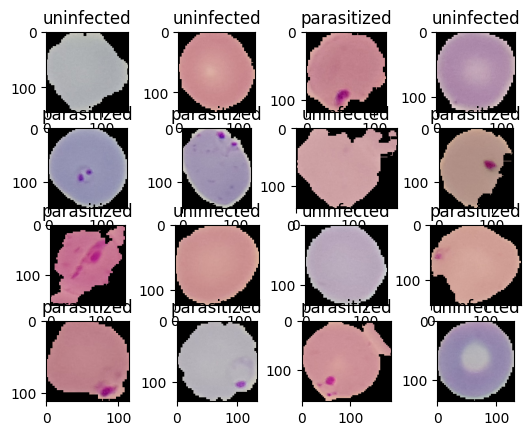

In [14]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))

## Data Preprocessing

In [40]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [41]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [15]:
for image, label in train_dataset.take(1):
  print(image.shape)

(224, 224, 3)


In [35]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(buffer_size=8).batch(BATCH_SIZE)

In [17]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [42]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Model

In [24]:
model = tf.keras.Sequential([InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2, strides=2),

                             Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2, strides=2),

                             Flatten(),

                             Dense(100, activation='sigmoid'),
                             BatchNormalization(),
                             Dense(10, activation='sigmoid'),
                             BatchNormalization(),
                             Dense(1, activation='sigmoid')]) # 0 or 1
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

### Loss function for binary classification: Binary Crossentropy

In [28]:
y_true = [0, 1, 0, 0]
y_pred = [0.8, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred) # bce value increases as difference increases

<tf.Tensor: shape=(), dtype=float32, numpy=5.1073575>

If we set 'from_logit=True', the loss function will apply sigmoid to the predicted value.

In [29]:
# In sigmoid, output is between 0 and 1
# from_logits=True
# the predicted values are not bounded between 0 and 1, and they are considered as unnormalized logits or raw model outputs
# the sigmoid activation is applied internally by the loss function.
# from_logits=False
# the predicted values are assumed to be already probabilities, and no additional activation is applied.
y_true = [0, 1, 0, 0]
y_pred = [0.8, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True) # applying sigmoid to the pred value
bce(y_true, y_pred) # bce value increases as difference increases

<tf.Tensor: shape=(), dtype=float32, numpy=1.0561078>

In [28]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1)

Epoch 1/3
517/517 [==============================] - 51s 93ms/step - loss: 0.6181 - accuracy: 0.6697 - val_loss: 0.6264 - val_accuracy: 0.6647
Epoch 2/3
517/517 [==============================] - 45s 87ms/step - loss: 0.5872 - accuracy: 0.6961 - val_loss: 0.6222 - val_accuracy: 0.6745
Epoch 3/3
517/517 [==============================] - 51s 100ms/step - loss: 0.5164 - accuracy: 0.7606 - val_loss: 0.4899 - val_accuracy: 0.7723


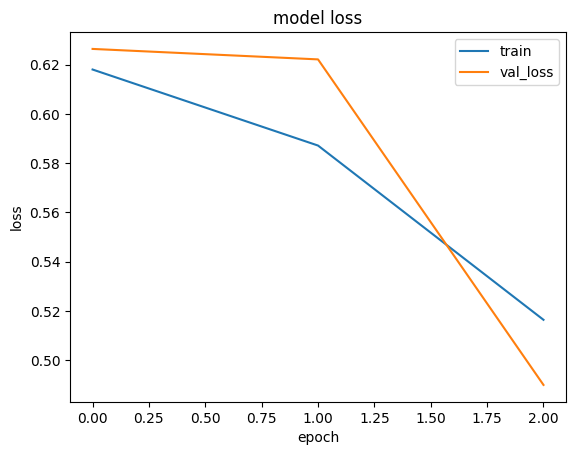

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

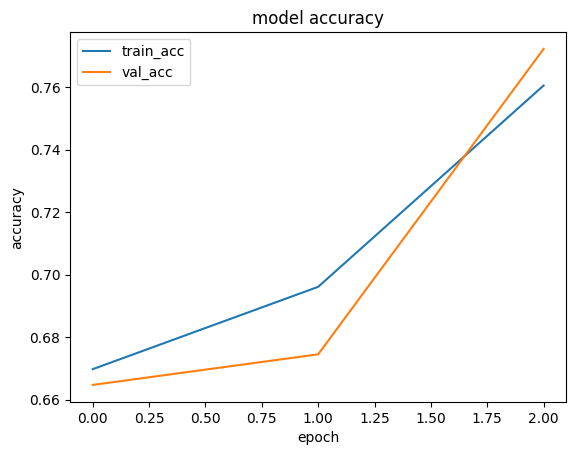

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()

## Model evaluation and testing

In [44]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [45]:
model.evaluate(test_dataset)

5513/5513 [==============================] - 34s 4ms/step - loss: 0.4976 - accuracy: 0.7689


[0.497560054063797, 0.7689098715782166]

Prediction

In [46]:
model.predict(test_dataset.take(1))

1/1 [==============================] - 11s 11s/step


array([[0.17294313]], dtype=float32)

In [47]:
def parasite_or_not(x):
  ax = plt.subplot(3,3,i+1)
  if (x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 21ms/step


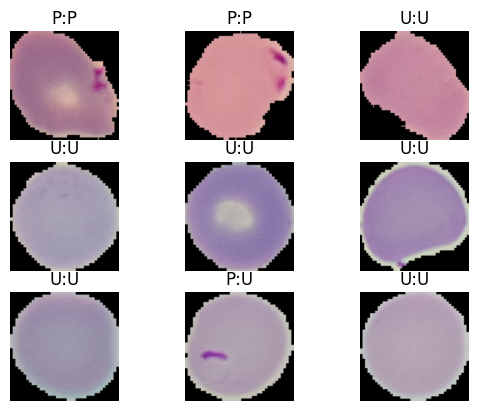

In [48]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(parasite_or_not(label.numpy()[0]) + ":"+ str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis("off")

## Saving models

Model weights and model configuration are different.

2 Saving Options

1. Save weight + config(metrics..) => package into the full model
2. Save weight  (if we are able to get config)

### 1. Saving weight + config

In [49]:
model.save("LenetSavedModel")

In [55]:
!ls -l /content/LenetSavedModel

total 420
drwxr-xr-x 2 root root   4096 Jun 24 10:54 assets
-rw-r--r-- 1 root root     57 Jun 24 10:54 fingerprint.pb
-rw-r--r-- 1 root root  27848 Jun 24 10:54 keras_metadata.pb
-rw-r--r-- 1 root root 388667 Jun 24 10:54 saved_model.pb
drwxr-xr-x 2 root root   4096 Jun 24 10:54 variables


In [53]:
loaded_model = tf.keras.models.load_model("LenetSavedModel")
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

#### hdf5: Lightweighted version of tf model

In [57]:
model.save("lenet.hdf5") # custom layers are not saved in this format

In [59]:
!ls -l lenet.hdf5

-rw-r--r-- 1 root root 56098496 Jun 24 10:58 lenet.hdf5


In [58]:
loaded_model = tf.keras.models.load_model("lenet.hdf5")
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

### 2. Saving only weights

In [60]:
model.save_weights("weights/lenet_weights")

In [61]:
!ls -l weights

total 54724
-rw-r--r-- 1 root root       83 Jun 24 11:01 checkpoint
-rw-r--r-- 1 root root 56025868 Jun 24 11:01 lenet_weights.data-00000-of-00001
-rw-r--r-- 1 root root     3836 Jun 24 11:01 lenet_weights.index


We can train the model right away with model.save(), but we need model config with model.save_weights()

In [63]:
lenet_weights_model = model.load_weights("weights/lenet_weights")
lenet_weights_model